<a id='0.1'></a>
## 0.1 load required packages

The link to get [ImageAnalysis3](https://github.com/zhengpuas47/ImageAnalysis3) 

or the Zhuang lab archived [source_tools](https://github.com/ZhuangLab/Chromatin_Analysis_2020_cell/tree/master/sequential_tracing/source)

In [1]:
%run "..\..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *

print(os.getpid())

# library design specific tools
from ImageAnalysis3.library_tools import LibraryDesigner as ld
from ImageAnalysis3.library_tools import LibraryTools as lt
# biopython imports
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast import NCBIXML

32520


In [3]:
## Some folders
# human genome
reference_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\mouse\GRCm38_ensembl'
genome_folder = os.path.join(reference_folder, 'Genome')
# Library directories
pool_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain'
library_folder = library_folder = os.path.join(pool_folder, f'mouse_genome_1000')

## 3.1 design readout mapping dict (region_to_readout)

idea for this library:

1. each gene has 3 on-bits from 99 total-bits

Example of HD [encoding](../resources/covering_v_99_k_3_t_2.txt) scheme in this repository

In [7]:
on_num = 3
total_num = 99

encoding_file = os.path.join(pool_folder, f'covering_v_{total_num}_k_{on_num}_t_2.txt')
loaded_bits = []

with open(encoding_file, 'r') as _handle:
    # start reading
    _lines = _handle.read().split('\n')
    for _line in _lines:
        _bits = [int(_i)-1 for _i in _line.split(' ') if len(_i) > 0]
        loaded_bits.append(_bits)

loaded_bits = np.array(loaded_bits, dtype=np.int)
print(np.shape(loaded_bits))

(1617, 3)


In [8]:
def convert_bits_to_matrix(bits):
    _matrix = np.ones([len(bits), np.max(bits)+1], dtype=np.int) * -1
    for _i, _b in enumerate(bits):
        _matrix[_i, _b] = 1
    return _matrix

In [11]:
# remove redundant bits
kept_bits = loaded_bits.copy()
kept_inds = np.zeros(len(kept_bits))
while np.sum(kept_inds) != len(kept_inds):
    kept_inds = np.ones(len(kept_bits), dtype=np.bool)
    _kept_mat = convert_bits_to_matrix(kept_bits)
    _dists = (total_num - (_kept_mat @ _kept_mat.T)) / 2
    _x, _y = np.where((_dists > 0) * (_dists <= 3))
    if len(_x) > 0:
        kept_inds[_x[0]] = False
        kept_bits = kept_bits[kept_inds]
        print(np.sum(kept_inds), kept_inds[_x[0]])
print(kept_bits.shape)

(1617, 3)


In [12]:
encoding_bits = kept_bits.copy()
encoding_mat = convert_bits_to_matrix(encoding_bits)

In [13]:
encoding_folder = os.path.join(pool_folder, 'Encoding_design')
if not os.path.exists(encoding_folder):
    os.makedirs(encoding_folder)
    print(encoding_folder)

pickle.dump(encoding_bits, open(os.path.join(encoding_folder, f'encoding_bits_total-{total_num}_on-{on_num}'), 'wb'))

\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\Encoding_design


Prepare the file below using the notebook

[1_library_design_ctp11](1_library_design_ctp11.ipynb)

In [4]:
chr_2_region_num = pickle.load( open(os.path.join(library_folder, 'chr_2_region_num.pkl'), 'rb'))

In [54]:
# assign into different chromosomes
cand_bits = list(encoding_bits)
total_bit_usage = np.zeros(np.max(cand_bits)+1)
chr_bit_usage_dict = {}
chr_2_region_bits = {}
for _chr, _num in sorted(chr_2_region_num.items(), key=lambda v:-v[1]):
    print(_chr, _num)
    chr_2_region_bits[_chr] = []
    # try to assign as even as possible for this chr
    _chr_bit_usage = np.zeros(np.max(cand_bits)+1)
    
    while len(chr_2_region_bits[_chr]) < _num:
        # for each cand_bit, estimate overlap
        _chr_usage_list = [np.sum(_chr_bit_usage[_bits]**2) for _bits in cand_bits]
        _total_usage_list = [np.sum(total_bit_usage[_bits]**2) for _bits in cand_bits]
        # find the least overlapping candidate
        _least_overlap_inds = []
        _chr_usage_th = np.min(_chr_usage_list)
        _total_usage_th = np.min(_total_usage_list)
        while len(_least_overlap_inds) == 0:
            _least_overlap_inds = np.intersect1d(np.where(np.array(_chr_usage_list)<=_chr_usage_th)[0], 
                                                np.where(np.array(_total_usage_list)<=_total_usage_th)[0])
            _total_usage_th += 1
        
        _rand_least_overlap_ind = _least_overlap_inds[np.random.randint(len(_least_overlap_inds))]
        
        print(_chr_bit_usage[cand_bits[_rand_least_overlap_ind]], 
              total_bit_usage[cand_bits[_rand_least_overlap_ind]],  
              _sel_cand)
        
        # remove this code from cand_bit pool
        _sel_cand = cand_bits.pop(_rand_least_overlap_ind)
        
        # update overlap list and chr_2_region_bits
        chr_2_region_bits[_chr].append(_sel_cand)
        _chr_bit_usage[_sel_cand] += 1
        total_bit_usage[_sel_cand] += 1
    
    chr_bit_usage_dict[_chr] = _chr_bit_usage

1 77
[0. 0. 0.] [0. 0. 0.] [89 94 95]
[0. 0. 0.] [0. 0. 0.] [12 87 91]
[0. 0. 0.] [0. 0. 0.] [ 7 27 61]
[0. 0. 0.] [0. 0. 0.] [15 32 48]
[0. 0. 0.] [0. 0. 0.] [ 8 20 56]
[0. 0. 0.] [0. 0. 0.] [64 72 74]
[0. 0. 0.] [0. 0. 0.] [45 46 89]
[0. 0. 0.] [0. 0. 0.] [43 55 75]
[0. 0. 0.] [0. 0. 0.] [41 81 85]
[0. 0. 0.] [0. 0. 0.] [39 84 88]
[0. 0. 0.] [0. 0. 0.] [21 60 83]
[0. 0. 0.] [0. 0. 0.] [ 3 35 49]
[0. 0. 0.] [0. 0. 0.] [ 5  6 13]
[0. 0. 0.] [0. 0. 0.] [ 2 25 30]
[0. 0. 0.] [0. 0. 0.] [11 62 65]
[0. 0. 0.] [0. 0. 0.] [16 50 71]
[0. 0. 0.] [0. 0. 0.] [69 70 82]
[0. 0. 0.] [0. 0. 0.] [29 37 57]
[0. 0. 0.] [0. 0. 0.] [40 59 90]
[0. 0. 0.] [0. 0. 0.] [67 92 98]
[0. 0. 0.] [0. 0. 0.] [17 34 52]
[0. 0. 0.] [0. 0. 0.] [24 33 58]
[0. 0. 0.] [0. 0. 0.] [ 4 38 77]
[0. 0. 0.] [0. 0. 0.] [ 9 18 42]
[0. 0. 0.] [0. 0. 0.] [28 31 68]
[0. 0. 0.] [0. 0. 0.] [23 36 63]
[0. 0. 0.] [0. 0. 0.] [78 86 94]
[0. 0. 0.] [0. 0. 0.] [44 66 97]
[0. 0. 0.] [0. 0. 0.] [10 22 47]
[0. 0. 0.] [0. 0. 0.] [ 0 80 95]
[1. 0

[1. 1. 1.] [7. 7. 7.] [21 37 73]
[1. 1. 1.] [7. 7. 7.] [ 6 71 80]
[1. 1. 1.] [7. 7. 7.] [59 61 75]
[1. 1. 1.] [7. 7. 7.] [ 5 23 29]
[1. 1. 1.] [7. 7. 7.] [ 3 53 97]
[1. 1. 1.] [8. 7. 7.] [31 32 90]
[1. 1. 1.] [7. 7. 8.] [13 25 54]
[1. 1. 1.] [7. 7. 8.] [ 1 89 93]
[1. 1. 1.] [8. 7. 7.] [ 9 55 62]
[1. 1. 1.] [8. 8. 7.] [17 36 87]
[1. 1. 1.] [8. 8. 8.] [12 40 85]
5 58
[0. 0. 0.] [8. 8. 8.] [16 65 83]
[0. 0. 0.] [8. 8. 8.] [28 50 78]
[0. 0. 0.] [8. 8. 8.] [ 4 29 89]
[0. 0. 0.] [8. 8. 8.] [31 42 75]
[0. 0. 0.] [8. 8. 8.] [48 54 57]
[0. 0. 0.] [8. 8. 8.] [11 30 61]
[0. 0. 0.] [8. 8. 8.] [21 25 45]
[0. 0. 0.] [8. 8. 8.] [ 7 53 66]
[0. 0. 0.] [8. 8. 8.] [27 71 94]
[0. 0. 0.] [8. 8. 8.] [15 46 63]
[0. 0. 0.] [8. 8. 8.] [20 73 97]
[0. 0. 0.] [8. 8. 8.] [ 1 59 82]
[0. 0. 0.] [8. 8. 8.] [22 58 69]
[0. 0. 0.] [8. 8. 8.] [26 43 91]
[0. 0. 0.] [8. 8. 8.] [ 2 70 81]
[0. 0. 0.] [8. 8. 8.] [14 44 67]
[0. 0. 0.] [8. 8. 8.] [ 0 19 92]
[0. 0. 0.] [8. 8. 8.] [41 52 68]
[0. 0. 0.] [8. 8. 8.] [ 6 33 51]
[0. 0

[0. 0. 0.] [14. 14. 14.] [43 77 87]
[0. 0. 0.] [14. 14. 15.] [ 7 26 67]
[0. 0. 0.] [14. 15. 14.] [19 91 98]
[0. 0. 0.] [15. 14. 14.] [ 1 11 20]
[0. 0. 0.] [14. 14. 15.] [32 63 73]
[0. 0. 0.] [14. 15. 14.] [37 51 74]
[0. 0. 0.] [15. 15. 15.] [ 4  5 15]
[0. 0. 0.] [15. 15. 15.] [59 83 97]
[0. 0. 0.] [15. 15. 15.] [29 44 56]
[0. 0. 0.] [15. 15. 15.] [13 23 90]
[0. 0. 0.] [15. 15. 15.] [ 8 14 71]
[0. 0. 0.] [15. 15. 15.] [38 78 82]
[0. 0. 0.] [15. 15. 15.] [28 69 88]
[0. 0. 0.] [15. 15. 15.] [18 53 84]
[0. 0. 0.] [15. 15. 15.] [ 3 57 80]
[0. 0. 0.] [15. 15. 15.] [12 55 70]
[0. 0. 0.] [15. 15. 15.] [ 6 89 96]
[0. 0. 0.] [15. 15. 15.] [49 50 72]
[0. 0. 0.] [15. 15. 15.] [16 54 68]
[0. 0. 0.] [15. 15. 15.] [30 40 81]
[0. 0. 0.] [15. 15. 15.] [25 47 93]
[0. 0. 0.] [15. 15. 15.] [31 34 79]
[0. 0. 0.] [15. 15. 15.] [27 64 66]
[0. 0. 0.] [15. 15. 15.] [21 35 41]
[0. 0. 0.] [15. 15. 15.] [22 33 95]
[0. 0. 0.] [15. 15. 15.] [ 0 52 75]
[0. 0. 0.] [15. 15. 15.] [10 48 86]
[0. 0. 0.] [15. 15. 15.] [17

[1. 1. 1.] [21. 21. 21.] [26 46 77]
[1. 1. 1.] [21. 22. 21.] [ 1 55 66]
[1. 1. 1.] [21. 21. 22.] [25 35 56]
[1. 1. 1.] [21. 22. 21.] [14 34 85]
[1. 1. 1.] [21. 22. 22.] [21 50 96]
[1. 1. 1.] [22. 22. 21.] [11 67 84]
[1. 1. 1.] [22. 22. 21.] [39 41 98]
[1. 1. 1.] [22. 22. 22.] [ 7 40 71]
12 43
[0. 0. 0.] [22. 22. 22.] [33 42 74]
[0. 0. 0.] [22. 22. 22.] [ 5 53 62]
[0. 0. 0.] [22. 22. 22.] [23 46 82]
[0. 0. 0.] [22. 22. 22.] [13 78 79]
[0. 0. 0.] [22. 22. 22.] [21 29 95]
[0. 0. 0.] [22. 22. 22.] [20 38 66]
[0. 0. 0.] [22. 22. 22.] [ 1 17 45]
[0. 0. 0.] [22. 22. 22.] [26 71 96]
[0. 0. 0.] [22. 22. 22.] [22 36 48]
[0. 0. 0.] [22. 22. 22.] [18 80 93]
[0. 0. 0.] [22. 22. 22.] [ 2 34 69]
[0. 0. 0.] [22. 22. 22.] [ 6 24 30]
[0. 0. 0.] [22. 22. 22.] [ 3 83 98]
[0. 0. 0.] [22. 22. 22.] [19 76 87]
[0. 0. 0.] [22. 22. 22.] [44 72 88]
[0. 0. 0.] [22. 22. 22.] [ 9 70 94]
[0. 0. 0.] [22. 22. 22.] [ 8 60 86]
[0. 0. 0.] [22. 22. 22.] [11 14 73]
[0. 0. 0.] [22. 22. 22.] [15 57 65]
[0. 0. 0.] [22. 22. 22

[0. 0. 1.] [29. 29. 29.] [19 38 80]
[1. 0. 0.] [29. 29. 29.] [ 8 18 58]
19 23
[0. 0. 0.] [28. 29. 29.] [28 34 83]
[0. 0. 0.] [29. 29. 28.] [60 82 98]
[0. 0. 0.] [29. 29. 29.] [30 46 59]
[0. 0. 0.] [29. 29. 29.] [23 45 53]
[0. 0. 0.] [29. 29. 29.] [36 68 95]
[0. 0. 0.] [29. 29. 29.] [ 5 35 74]
[0. 0. 0.] [29. 29. 29.] [41 77 89]
[0. 0. 0.] [29. 29. 29.] [40 48 50]
[0. 0. 0.] [29. 29. 29.] [11 15 27]
[0. 0. 0.] [29. 29. 29.] [21 81 92]
[0. 0. 0.] [29. 29. 29.] [57 70 91]
[0. 0. 0.] [29. 29. 29.] [33 84 85]
[0. 0. 0.] [29. 29. 29.] [32 51 79]
[0. 0. 0.] [29. 29. 29.] [10 20 90]
[0. 0. 0.] [29. 29. 29.] [63 72 78]
[0. 0. 0.] [29. 29. 29.] [13 37 75]
[0. 0. 0.] [29. 29. 29.] [14 16 29]
[0. 0. 0.] [29. 29. 29.] [ 1  9 73]
[0. 0. 0.] [29. 29. 29.] [17 43 96]
[0. 0. 0.] [29. 29. 29.] [12 49 86]
[0. 0. 0.] [29. 29. 29.] [26 44 62]
[0. 0. 0.] [29. 30. 29.] [ 3  4 69]
[0. 0. 0.] [29. 30. 29.] [54 58 67]
Y 1
[0. 0. 0.] [29. 30. 29.] [24 64 87]


<IPython.core.display.Javascript object>


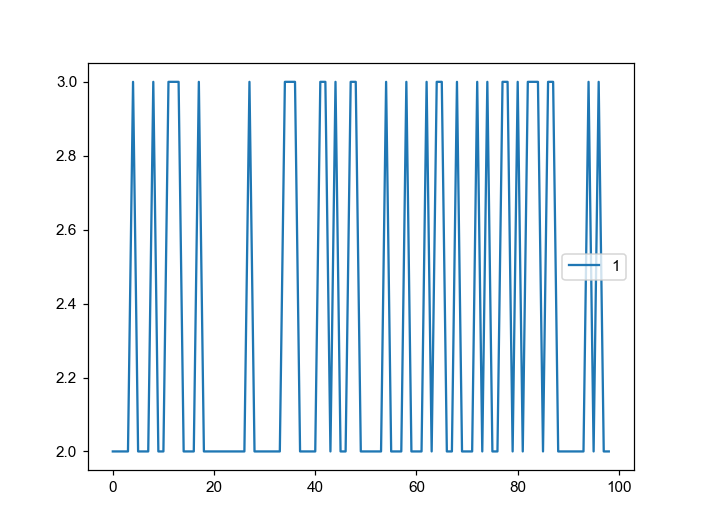

In [58]:
fig, ax = plt.subplots()
for _chr, _chr_bit_usage in chr_bit_usage_dict.items():
    ax.plot(_chr_bit_usage, label=_chr, )
    break
ax.legend()

In [59]:
def calculate_closest_overlap(code_list, code, _localtion):
    """Calculate the closest neighbor of certain code at certain location"""
    if _localtion > len(code_list) or _localtion < 0:
        raise ValueError(f"invalid _location")
    _code_list = np.array(code_list)
    if len(_code_list) == 0:
        return np.inf
    else:
        _min_dists = []
        for _c in code:
            if not (_code_list==_c).any():
                _min_dists.append(np.inf)
            else:
                _match_loc,_  = np.where(_code_list == _c)
                _dists = np.abs(_match_loc - _localtion)
                _dists[_match_loc >= _localtion] += 1
                _min_dists.append(np.min(_dists))

    return np.float(np.min(_min_dists))

In [61]:
sorted_chr_bits = {}
sorted_chr_dists = {}
for _chr, _chr_bits in chr_bit_usage_dict.items():
    print(_chr)
    _chr_bits = np.array(chr_2_region_bits[_chr])
    code_degrees = np.array([np.sum(chr_bit_usage_dict[_chr][_b])-3 for _b in _chr_bits])

    final_codes = []
    final_dist = 0

    # it seems the random doesnt help
    for _iter in range(1000):
        ordered_codes = []
        #ordered_codes = [tuple(_c) for _c in _chr_bits[np.where(code_degrees==np.min(code_degrees))]]
        #random.shuffle(ordered_codes)
        #for _degree in np.unique(code_degrees)[1:]:
        for _degree in np.unique(code_degrees):
            _cand_codes = [tuple(_c) for _c in _chr_bits[np.where(code_degrees==_degree)]]
            #print(_cand_codes, len(_cand_codes))
            #random.shuffle(_cand_codes)
            #print(_cand_codes, len(_cand_codes))
            for _code in _cand_codes:
                _dists = []
                for _i in range(0, len(ordered_codes)+1):
                    _dists.append(calculate_closest_overlap(ordered_codes, _code, _i))
                ordered_codes.insert(np.argmax(_dists), _code)
                #print(_dists, np.argmax(_dists))

        # check order
        final_dists = []
        for _i, _code in enumerate(ordered_codes):
            _other_codes = [_c for _j, _c in enumerate(ordered_codes) if _i != _j]
            final_dists.append(calculate_closest_overlap(_other_codes, _code, _i))
        if min(final_dists) > final_dist:
            final_dist = min(final_dists)
            final_codes = [np.array(_c) for _c in ordered_codes]
            print(min(final_dists), 'change')
    
    sorted_chr_bits[_chr] = np.array(final_codes)
    sorted_chr_dists[_chr] = np.array(final_dists)

1
7.0 change
2
11.0 change
3
7.0 change
4
12.0 change
5
11.0 change
6
9.0 change
X
12.0 change
10
7.0 change
8
8.0 change
7
10.0 change
9
14.0 change
11
10.0 change
13
11.0 change
12
13.0 change
14
11.0 change
15
12.0 change
16
14.0 change
17
24.0 change
18
26.0 change
19
inf change
Y
inf change


In [64]:
# save
chr_2_region_names = pickle.load(open(os.path.join(library_folder,'chr_2_region_names.pkl'), 'rb'))

In [65]:
# assemble to regionrate region_to_encoding_bits
region_2_bits = {}
for _chr in sorted_chr_bits:
    _chr_bits = sorted_chr_bits[_chr]
    _region_names = chr_2_region_names[_chr]
    print(_chr, len(_chr_bits), len(_region_names))
    region_2_bits.update({_g:_b for _g, _b in zip(_region_names, _chr_bits)})

1 77 77
2 70 70
3 61 61
4 59 59
5 58 58
6 58 58
X 56 56
10 51 51
8 50 50
7 49 49
9 48 48
11 48 48
13 45 45
12 43 43
14 42 42
15 40 40
16 38 38
17 36 36
18 35 35
19 23 23
Y 1 1


In [67]:
pickle.dump(region_2_bits, open(os.path.join(encoding_folder, f'region_2_bits.pkl'), 'wb'))

In [69]:
region_2_bits

{1: array([36, 62, 77]),
 2: array([17, 42, 86]),
 3: array([34, 72, 82]),
 4: array([57, 58, 94]),
 5: array([41, 78, 93]),
 6: array([61, 65, 80]),
 7: array([66, 74, 83]),
 8: array([23, 44, 54]),
 9: array([ 4, 45, 90]),
 10: array([51, 64, 75]),
 11: array([12, 67, 69]),
 12: array([15, 43, 68]),
 13: array([30, 31, 62]),
 14: array([10, 22, 47]),
 15: array([ 5,  6, 13]),
 16: array([ 3, 35, 49]),
 17: array([39, 84, 88]),
 18: array([ 8, 20, 56]),
 19: array([24, 32, 55]),
 20: array([18, 29, 73]),
 21: array([53, 89, 91]),
 22: array([ 7, 14, 63]),
 23: array([ 0, 37, 81]),
 24: array([70, 95, 97]),
 25: array([26, 28, 60]),
 26: array([11, 68, 74]),
 27: array([21, 56, 85]),
 28: array([54, 83, 87]),
 29: array([ 2, 76, 79]),
 30: array([48, 51, 96]),
 31: array([ 8, 44, 65]),
 32: array([ 1, 19, 53]),
 33: array([ 5, 27, 33]),
 34: array([67, 92, 98]),
 35: array([10, 52, 58]),
 36: array([12, 34, 42]),
 37: array([ 4, 38, 77]),
 38: array([40, 59, 90]),
 39: array([29, 37, 5

In [70]:
region_2_readout_dict = {}
for _iregion, _region in enumerate(region_2_bits):
    region_2_readout_dict[_region] = []#[f"u{_iregion}"]
    region_2_readout_dict[_region].extend([f"c{_b}" for _b in region_2_bits[_region]])

# save
pickle.dump(region_2_readout_dict, open(os.path.join(library_folder, 'region_2_readout.pkl'), 'wb'))

In [72]:
region_2_readout_dict

{1: ['c36', 'c62', 'c77'],
 2: ['c17', 'c42', 'c86'],
 3: ['c34', 'c72', 'c82'],
 4: ['c57', 'c58', 'c94'],
 5: ['c41', 'c78', 'c93'],
 6: ['c61', 'c65', 'c80'],
 7: ['c66', 'c74', 'c83'],
 8: ['c23', 'c44', 'c54'],
 9: ['c4', 'c45', 'c90'],
 10: ['c51', 'c64', 'c75'],
 11: ['c12', 'c67', 'c69'],
 12: ['c15', 'c43', 'c68'],
 13: ['c30', 'c31', 'c62'],
 14: ['c10', 'c22', 'c47'],
 15: ['c5', 'c6', 'c13'],
 16: ['c3', 'c35', 'c49'],
 17: ['c39', 'c84', 'c88'],
 18: ['c8', 'c20', 'c56'],
 19: ['c24', 'c32', 'c55'],
 20: ['c18', 'c29', 'c73'],
 21: ['c53', 'c89', 'c91'],
 22: ['c7', 'c14', 'c63'],
 23: ['c0', 'c37', 'c81'],
 24: ['c70', 'c95', 'c97'],
 25: ['c26', 'c28', 'c60'],
 26: ['c11', 'c68', 'c74'],
 27: ['c21', 'c56', 'c85'],
 28: ['c54', 'c83', 'c87'],
 29: ['c2', 'c76', 'c79'],
 30: ['c48', 'c51', 'c96'],
 31: ['c8', 'c44', 'c65'],
 32: ['c1', 'c19', 'c53'],
 33: ['c5', 'c27', 'c33'],
 34: ['c67', 'c92', 'c98'],
 35: ['c10', 'c52', 'c58'],
 36: ['c12', 'c34', 'c42'],
 37: ['c4', 